In [ ]:
import PyMieScatt as ps
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from matplotlib.contour import QuadContourSet
from PyMieScatt.Mie import Mie_ab
from matplotlib.collections import LineCollection
from scipy.ndimage import zoom
from scipy.integrate import trapz
from shapely import geometry
from mpl_toolkits import mplot3d

# Method using Fourier spectrum 
### *(article: Spectral solution of the inverse Mie problem)*

### Study of the link between the exactness of the results given by the method using Fourier spectrum

We chose to study the link between the resolution used for the scattering angle $\theta$ (10° to 20°) and the errors on $x$ and $m$. We applied the "Fourier method" for a given wavelength $\lambda$ and plot the evolution of the errors depending on the resolution. 

In [ ]:
def Characterization(x,m,wl,pol,resolution):
    M = 4096
    #resolution = 0.2/(0.1*x)
    #print("r",resolution)
    d = x*wl/np.pi
    theta, SL,SR,SU = ps.ScatteringFunction(m,wl,d,minAngle = 10, maxAngle = 20, angleMeasure = 'degrees',angularResolution = resolution)
    if pol == 'SL': 
        I = SL 
    elif pol == 'SR':
        I = SR 
    elif pol == 'SU':
        I = SU 
    N = len(theta)
    w = (np.sin(np.pi*(theta-theta[0])/(theta[-1]-theta[0])))**2
    window = w*I 
    P = []
    angle = []
    for k in range(N):
        s = 0
        q = k/(N*resolution)
        for j in range(N):
            s += window[j]*np.exp(-1j*2*np.pi*q*j/N)
           
        P.append((1/len(theta))**2*(np.conjugate(s)*s).real)
        angle.append(q)
    #Find the peak 
    #Pass the first peak 
    cond = False
    ind = 0 
    while not(cond) and ind+1<len(P):
        if P[ind]-P[ind+1]>0:
            ind+=1
        else: 
            cond = True 

    if ind+1 == len(P): 
        amp_peak = 0 
        angle_peak = 0 
        peak = [angle_peak,amp_peak]
    else: 
        amp_peak = max(P[ind:])
        angle_peak = np.where(P==amp_peak)[0]/(N*resolution)
        limit = np.where(P==amp_peak)[0]
        amp_min = min(P[ind:limit[0]])
        angle_min = np.where(P==amp_min)[0]/(N*resolution)
        minimum = [angle_min,amp_min]
        peak = [angle_peak,amp_peak]

    if peak[1] != 0:
        C = 1 - (amp_min/peak[1])
        #print('Weber contrast :',C)
    else:
        C = 0 
        #print('no contrast')
        
    return theta, I, window, angle, P, peak, C

In [ ]:
wl = 500
x_real = 75
m_real = 1.05

In [ ]:
N = 30 
error = np.zeros((N,2))
res = np.linspace(0.02,0.4,N)

for k in range(len(res)):

    print("chosen resolution for $\\theta$", res[k])
    x = np.linspace(60,100,13)
    m = np.linspace(1,1.5,13)
    d = x*wl/np.pi
    theta,I, window,angle,P,peak,C = Characterization(x_real,m_real,wl,'SL',res[k])
    #print("Pour une taille :",x,", un indice de réfraction :",m,", une longueur d'onde :",wl)
    """
    plt.plot(theta,I)
    plt.xlabel("Scattering angle $\\theta$ in degrees")
    plt.ylabel("Intensity")
    plt.title("SL depending on the scattering angle $\\theta$")
    plt.show()

    plt.plot(theta,window)
    plt.xlabel("Scattering angle $\\theta$")
    plt.ylabel("Intensity w.I")
    plt.title("Windowed intensity depending on the scattering angle")
    plt.show() 

    plt.plot(angle,P)
    plt.scatter(0,P[0],label ="$A_0$")
    plt.scatter(peak[0],peak[1],label = "$A_p$")
    plt.vlines(peak[0],0,max(P)/4,'g',linestyle = 'dashed',label = "L")
    plt.xlabel("Angular resolution q")
    plt.ylabel("Spectrum amplitude")
    plt.title("Power spectrum of the windowed I")
    plt.legend()
    plt.show()

    plt.plot(angle,P/P[0])
    plt.scatter(peak[0],peak[1]/P[0],label = "(L,Ap)")
    plt.xlabel("Angular resolution q")
    plt.ylabel("Normalized spectrum amplitude")
    plt.title("Graph of normalized spectrum amplitude")
    plt.legend()
    plt.show
    
    """
    
    L = np.zeros((len(x),len(m)))
    A0 = np.zeros((len(x),len(m)))
    value_x = np.zeros((len(x),len(m))) 
    value_m = np.zeros((len(x),len(m)))

    
    for i in range(len(x)):
        for j in range(len(m)): 
            #print(x[i],m[j])
            theta,I,window,angle,P,peak,C = Characterization(x[i],m[j],wl,'SL',res[k])
            L[i,j] = peak[0]
            A0[i,j] = P[0]
            value_x[i,j] = x[i]
            value_m[i,j] = m[j]
    """      
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca(projection = '3d') 
    ax.scatter(value_x,value_m,A0)
    ax.set_xlabel("size x")
    ax.set_ylabel("refractive index m")
    ax.set_zlabel("Amplitude of zero frequency $A_0$")
    ax.set_title("$A_0$ depending on x and m")
    plt.show()

    fig1 = plt.figure(figsize=(8,8))
    ax1 = plt.gca(projection='3d')
    ax1.scatter(value_x,value_m,L)
    ax1.set_xlabel("size x")
    ax1.set_ylabel("refractive index m")
    ax1.set_zlabel("Peak location L")
    ax1.set_title("L depending on x and m")
    ax1.view_init(30,30)
    plt.show()

    fig2 = plt.figure(figsize=(8,8))
    ax2 = plt.gca(projection = '3d')
    ax2.scatter(A0,L,value_x)
    ax2.set_ylabel("Peak location L")
    ax2.set_xlabel("Amplitude of zero frequency A0")
    ax2.set_zlabel("size x") 
    ax2.set_title("x depending on L and $A_0$")
    plt.show()

    fig3 = plt.figure(figsize=(8,8))
    ax3 = plt.gca(projection = '3d')
    ax3.scatter(A0,L,value_m)
    ax3.set_ylabel("Peak location L")
    ax3.set_xlabel("Amplitude of zero frequency A0")
    ax3.set_zlabel("refractive index m") 
    ax3.set_title("m depending on L and $A_0$")
    plt.show()
    """
    
    diff = 10
    for ind in range(len(x)): 
        if abs(x_real-x[ind])<diff:
            _ind = ind
    _x = x[_ind-1]
    #print("_x :",_x)
    
    plt.plot(m,A0[_ind,:])
    plt.title("$A_0$ depending on m at x="+str(_x))
    plt.xlabel("Refractive index m")
    plt.ylabel("Amplitude at zero frequency $A_0$")   


    i = 1
    cond = False
    while i+1<len(A0[_ind,:]) and not(cond):
        if A0[_ind,i]>A0[_ind,i+1] and A0[_ind,i]>A0[_ind,i-1]:
            cond = True 
        i+=1
    """
    plt.vlines(m[i-1],0,max(A0[_ind,:]),label="Uniqueness threshold") 
    plt.legend()
    plt.show()
    """
    j = 1
    cond1 = False
    while j+1 < len(A0[_ind,:]) and not(cond1):
        if (A0[_ind,j]<A0[_ind,j+1]) and (A0[_ind,j]<A0[_ind,j-1]):
            cond1 = True
        j+=1

    m_max1 = m[j-1]
    #print(m_max1,m)
    for i in range(len(m)): 
        if A0[_ind,j-1]>A0[_ind,i] and A0[_ind,j-1]<A0[_ind,i+1]: 
            m_max2 = m[i]

    m_max = min(m_max1,m_max2)
    #print(m_max)
    """
    plt.plot(m,A0[_ind,:],'o')
    plt.title("$A_0$ depending on m at x="+str(_x))
    plt.xlabel("Refractive index m")
    plt.ylabel("Amplitude at zero frequency $A_0$")  
    plt.hlines(A0[_ind,j-1],m[0],m[-1],'r','dashed',label="Uniqueness threshold, signal-based")
    plt.legend()
    plt.show()
    """
    #print("m_max :", m_max)
    m_r = np.linspace(1,m_max,13)
    d = x*wl/np.pi

    L_r = np.zeros((len(x),len(m_r)))
    A0_r = np.zeros((len(x),len(m_r)))
    value_x = np.zeros((len(x),len(m_r))) 
    value_m_r = np.zeros((len(x),len(m_r)))

    for i in range(len(x)):
        for j in range(len(m_r)): 
            #print(x[i],m_r[j])
            theta,I,window,angle,P,peak,C = Characterization(x[i],m_r[j],wl,'SL',res[k])
            L_r[i,j] = peak[0]
            A0_r[i,j] = P[0]
            value_x[i,j] = x[i]
            value_m_r[i,j] = m_r[j]
    B0 = np.sqrt(np.sqrt(A0_r))/L_r
    """
    fig4 = plt.figure(figsize=(8,8))
    ax4 = plt.gca(projection = '3d')
    ax4.scatter(B0,L_r,value_x)
    ax4.set_ylabel("Peak location L")
    ax4.set_xlabel("Linearized amplitude $B_0$")
    ax4.set_zlabel("size x") 
    ax4.set_title("x depending on L and $B_0$")
    plt.show()

    fig5 = plt.figure(figsize=(8,8))
    ax5 = plt.gca(projection='3d')
    ax5.scatter(B0,L_r,value_m_r)
    ax5.set_xlabel("Linearized amplitude $B_0$")
    ax5.set_ylabel("Peak Location L")
    ax5.set_zlabel("Refractive index m")
    ax5.set_title("m depending on L and $B_0$")
    ax5.view_init(30,70)
    plt.show()
    """
    coef_x = 0 
    for c in range(len(m_r)):
        coef_x += (x[0]-x[5])/(L_r[0,c]-L_r[5,c])
    coef_x = coef_x/len(m_r)
    print("coef x :", coef_x)
    
    coef_m = 0 
    for c in range(len(x)):
        coef_m += (m_r[0]-m_r[5])/(B0[c,0]-B0[c,5])
    coef_m = coef_m/len(x)
    print("coef m :", coef_m)
    
    theta,I, window,angle,P,peak,C = Characterization(x_real,m_real,wl,'SL',res[k])
    x_exp = coef_x*peak[0]
    x_error = npl.norm(x_exp-x_real)
    print("The experimental size x:", x_exp)
    print("The real size x:", x_real)
    print("Error:",x_error)

    m_exp = 1 + coef_m*(np.sqrt(np.sqrt(P[0]))/peak[0])
    m_error = npl.norm(m_exp-m_real)
    print("The experimental refractive index:", m_exp)
    print("The real refractive index:",m_real)
    print("Error:",m_error)
    error[k,0] = x_error
    error[k,1] = m_error

np.savetxt('Res_error.txt', error)

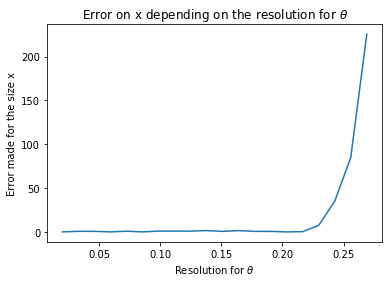

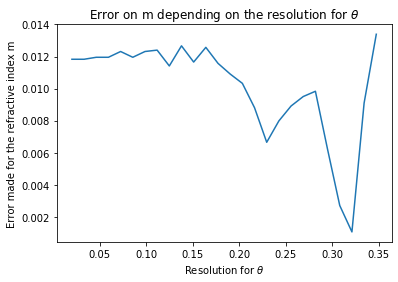

In [ ]:
plt.plot(res[:-4],error[:-4,0])
plt.title("Error on x depending on the resolution for $\\theta$")
plt.xlabel("Resolution for $\\theta$")
plt.ylabel("Error made for the size x")
plt.show()

plt.plot(res,error[:,1])
plt.title("Error on m depending on the resolution for $\\theta$")
plt.xlabel("Resolution for $\\theta$")
plt.ylabel("Error made for the refractive index m")
plt.show()

### **Analysis of the results for the size x**
The link between the error on $x$ and on the resolution was highly predictible. Indeed, when the resolution chosen for the scattering angle is to big, the angular resolution $q$ is bigger and our method won't be able to find the peak ($L$ and $A_p$). If those values aren't found or aren't correct the following calculations for the size won't be correct either because $x = \alpha L$ (as shown in the article). To conclude, when the $\theta$ resolution increases (i.e the angular resolution $q$ increases), the error between $x^*$ and $x_{exp}$ increases as well. But this rise isn't linear. Our method works without any alteration to retrieve the size $x$ for a resolution up to **0.22**. 

### **Analysis of the results for the refractive index m**
On the other hand, the effect of the resolution on the refractive index is quite poor. On the graph we can see a sharp decrease of the error and right after a sharp increase. Indeed, the formula to retrieve the refractive index is $m_exp = 1 + \beta B_0 = 1+  \beta \frac{A_0^{1/4}}{L}$. The resolution will affect the exactness of the peak $L$ but won't have any effect on $A_0$. That is why the resolution of the scattering angle a less effect on $m$ than on $x$. The variation of the errors aren't so meaningful given the narrow scale on the graph (biggest error 0.012 and smallest error 0.002). 